In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


# Import data

In [6]:
# We do not need the labels, since this is not a label classification problem
# (It is a classification problem, but between true and fake)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
print("Number of train inputs: " + str(len(x_train)))
print("Number of  test inputs: " + str(len(x_test)))

Number of train inputs: 60000
Number of  test inputs: 10000


In [0]:
# Define class to normalize and center pixels, and to flatten the image
class ImageScaler:
  def __init__(self, min=-1, max=+1, dtype=np.float32):
    assert max > min
    self.target_min = min
    self.target_max = max
    self.target_dtype = np.float32
    self.fitted = False
  
  def fit(self, x):
    if not self.fitted:
      self.min = x.min()
      self.max = x.max()
      self.dtype = x.dtype
      self.shape = x.shape[1:]
      self._scale = (self.target_max - self.target_min) / (self.max - self.min)
      self.fitted = True

  def transform(self, x):
    if self.fitted:
      # Bring pixels within [target_min, target_max]
      x = (x - self.min) * self._scale  + self.target_min
      # Flattem and change dtype
      x = x.reshape(-1, np.prod(self.shape, dtype=int)).astype(self.target_dtype)
    return x
  
  def fit_and_transform(self, x):
    self.fit(x)
    return self.transform(x)

  def transform_back(self, x):
    if self.fitted:
      # Bring pixels back to original range [min, max]
      x = (x - self.target_min) / self._scale + self.min
      # Bring back to original shape and dtype
      if len(x.shape) == 1:
        x = x.reshape(self.shape).astype(self.dtype) 
      else:
        x = x.reshape(-1, *self.shape).astype(self.dtype) 
    return x

In [7]:
# Normalize pixels in range [-1, 1], and flatten the images
scaler = ImageScaler()
x_train = scaler.fit_and_transform(x_train)
x_test = scaler.transform(x_test)
print(f"Image shape before: {scaler.shape}")
print(f"Image shape after : {x_train.shape[1:]}")
print(f"Image pixel range before: [{scaler.min}, {scaler.max}]")
print(f"Image pixel range after : [{x_train.min()}, {x_train.max()}]")

Image shape before: (28, 28)
Image shape after : (784,)
Image pixel range before: [0, 255]
Image pixel range after : [-1.0, 1.0]


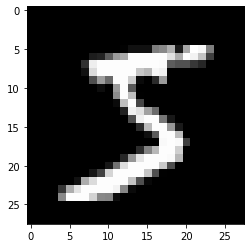

In [8]:
# transform_back() brings back the original image
plt.imshow(scaler.transform_back(x_train[0]), cmap='gray')
plt.show()

In [0]:
# Function to sample images with a generator (defined below).
# The min and max pixel values of the generator output must be the same as the
# scaler's targets. For example, to ensure values within [-1, +1], we must use
# tanh() as output activation function.
import os

def sample_images(generator, scaler=None, epoch=0, rows=5, cols=5, show=True,
                  path=None):
  n_imgs = rows * cols
  latent_dim = generator.input_shape[1:]
  
  noise = np.random.randn(n_imgs, *latent_dim)
  imgs = generator.predict(noise)
  if scaler: imgs = scaler.transform_back(imgs)

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx], cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  
  if show: plt.show()

  if path:
    # Create a folder to store generated images
    if not os.path.exists(path): os.makedirs(path)
    path = f"{path}/{epoch}.png"
    fig.savefig(path)
    plt.close()
    return path
  
  plt.close()

# Define generator, discriminator, train function

In [0]:
def create_generator(latent_dim, n_pixels, name="generator"):
  i = Input(shape=(latent_dim,))
  x = i
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(n_pixels, activation='tanh')(x)  # tanh() to bring pixels in (-1, 1)
  return Model(i, x, name=name)

def create_discriminator(n_pixels, name='discriminator'):
  i = Input(shape=(n_pixels, ))
  x = i
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(1, activation='sigmoid')(x)  # output is probability of true
  return Model(i, x, name=name)

We define a function to train the GAN. We train the discriminator and the generator simultaneously, to let both improve while competing.

If a combined model is specificed, then this is trained in place of the generator. Otherwise, the generator is trained directly. We anyway need to specify the generator, beacuse this is used to train the discriminator.

In [0]:
# Note that the number of epochs here is not intended in the traditional sense.
# We do not process all real images in a epoch. Instead, in each epoch we show
# batch_size number of both real and fake images to the discriminator, and we
# let the generator generate 2*batch_size of images (so that it does not lag
# behind in training progress).

from datetime import datetime, timedelta

def train_gan(generator, discriminator, combined=None, scaler=None, epochs=1,
              batch_size=32, path=None, n_msg=100, n_samples=50):

  if not combined: combined = generator

  real = np.zeros(batch_size)
  fake = np.ones(batch_size)

  n_train = len(x_train)
  latent_dim = generator.input_shape[1:]

  epoch_msg = max(1, (epochs // n_msg))
  epoch_samples = max(1, (epochs // n_samples))

  g_loss = []
  d_loss = []
  g_acc = []
  d_acc = []
  images = []

  t0 = datetime.now()
  g_time, d_time = (timedelta(), timedelta())
  for epoch in range(epochs):
    # 1) Train the discriminator on real and fake images
    t1 = datetime.now()
    fake_imgs = generator.predict(np.random.randn(batch_size, *latent_dim))
    real_imgs = x_train[np.random.randint(0, n_train, batch_size)]
    loss_fake, acc_fake = discriminator.train_on_batch(fake_imgs, fake)
    loss_real, acc_real = discriminator.train_on_batch(real_imgs, real)
    d_loss.append(0.5 * (loss_fake + loss_real))
    d_acc.append(0.5 * (acc_fake + acc_real))
    d_time += datetime.now() - t1
    # 2) Train the generator to produce realistic images
    t1 = datetime.now()
    noise = np.random.randn(batch_size, *latent_dim)
    loss_g, acc_g = combined.train_on_batch(noise, real)  # target are real(istic) images
    noise = np.random.randn(batch_size, *latent_dim)
    loss_g, acc_g = combined.train_on_batch(noise, real)  # second time for parity
    g_loss.append(loss_g)
    g_acc.append(acc_g)
    g_time += datetime.now() - t1
    # 3) Print statistics and sample images
    if epoch % epoch_msg == 0:
      print(f"Epoch {epoch+1}/{epochs}"
            f", d_loss: {d_loss[-1]:.2f}, d_acc: {d_acc[-1]:.2f}, [{d_time}]"
            f", g_loss: {g_loss[-1]:.2f} g_acc: {g_acc[-1]:.2f}, [{g_time}]")
      g_time, d_time = (timedelta(), timedelta())
    if path and (epoch % epoch_samples == 0):
      images.append(sample_images(generator, scaler, epoch, show=False, path=path))
  
  print(f"Total training time: {datetime.now() - t0}")

  return {'g_loss': g_loss, 'd_loss': d_loss, 'g_acc': g_acc, 'd_acc': d_acc, 
          'images': images}

# Train option 1: combined model

We train the discriminator directly, and the generator via the combined model with discriminator frozen.

In [0]:
n_pixels = x_train.shape[1]
latent_dim = 100

generator = create_generator(latent_dim, n_pixels)
discriminator = create_discriminator(n_pixels)

# Combined model
i = Input(shape=(latent_dim,))
x = discriminator(generator(i))
combined = Model(i, x, name="combined")

Therefore, we first compile the discriminator, then we freeze it to compile the combined model (this will not affect the already compiled discriminator).

In [56]:
# Same training functions for both models
d_optimizer = tf.optimizers.Adam()
d_loss_fn = tf.losses.BinaryCrossentropy()
d_metric = tf.metrics.Accuracy()

# We want to train the discriminator directly, so we compile it.
discriminator.trainable = True
discriminator.compile(
    optimizer=d_optimizer,
    loss=d_loss_fn,
    metrics=[d_metric]
)
discriminator.summary()
print()

# We do not train the generator standalone. Therefore, we do not compile it.
# We train the the combined model, while freezing the discriminator.
discriminator.trainable = False
combined.compile(
    optimizer=d_optimizer,
    loss=d_loss_fn,
    metrics=[d_metric]
)
# all discriminator weights are still trainable (but reported twice, as non-trainable, too)
discriminator.summary()
print()
combined.summary()  # only generator weights are trainable
print()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_73 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 784)]             0         
_______________________

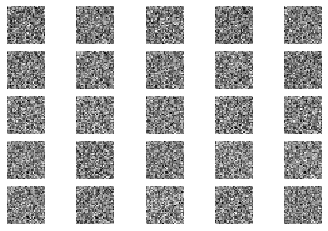

In [64]:
# The generator only generates some random noise before training
sample_images(generator, scaler)

We train the discriminator, and the combined model prepared above.

In [0]:
history = train_gan(generator, discriminator, combined, scaler, epochs=15000,
                    path='gan_images/mnist')

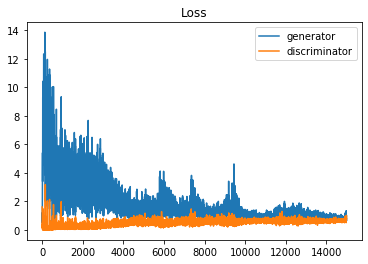

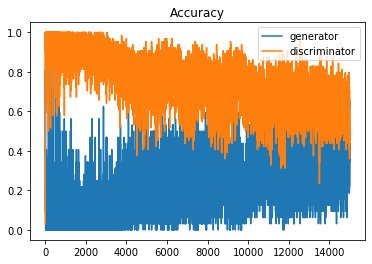

In [0]:
# Both generator and discriminator improve over time, so that loss and accuracy
# remain stable.
plt.plot(history['g_loss'], label='generator')
plt.plot(history['d_loss'], label='discriminator')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history['g_acc'], label='generator')
plt.plot(history['d_acc'], label='discriminator')
plt.title('Accuracy')
plt.legend()
plt.show()

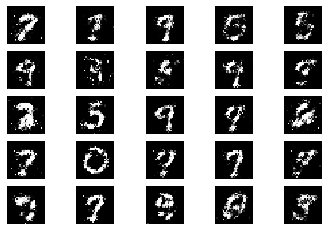

In [0]:
# The generator has learnt to turn input noise into realistic images
sample_images(generator, scaler)

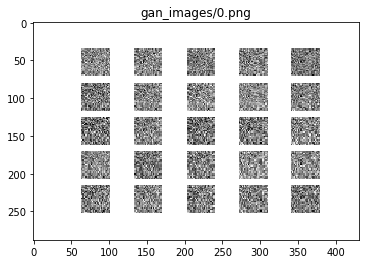

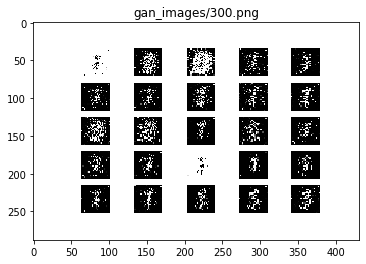

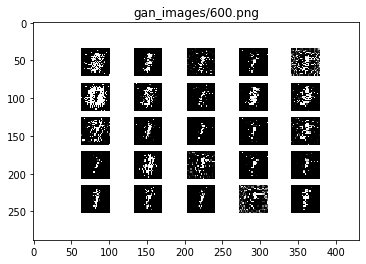

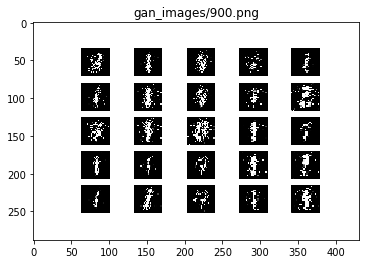

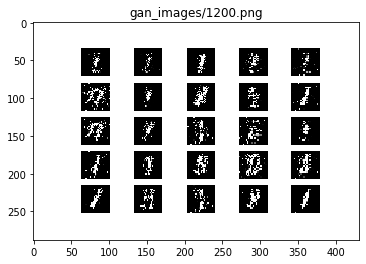

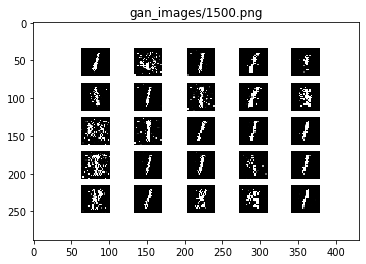

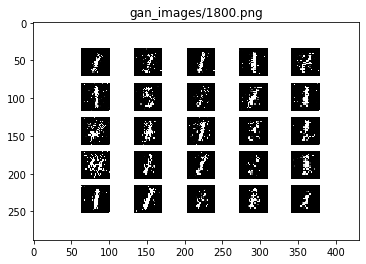

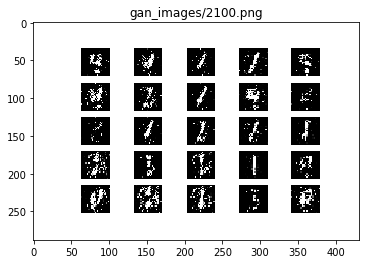

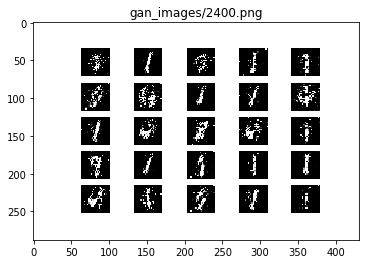

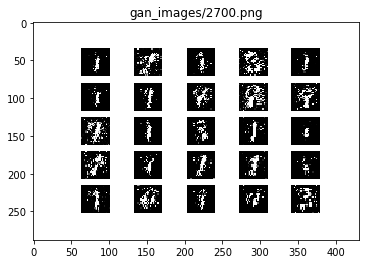

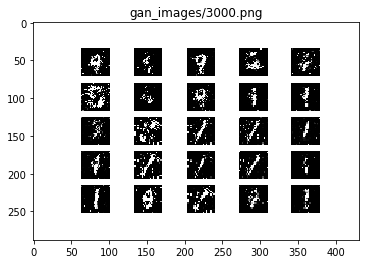

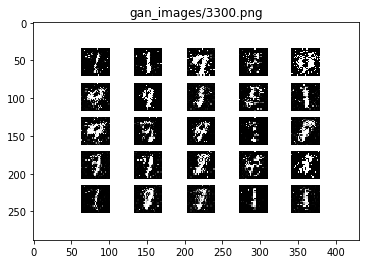

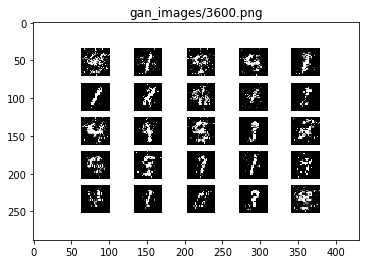

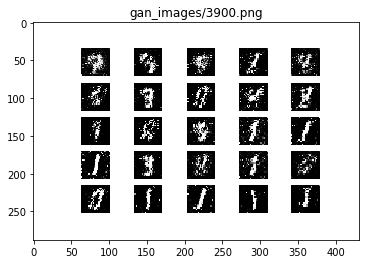

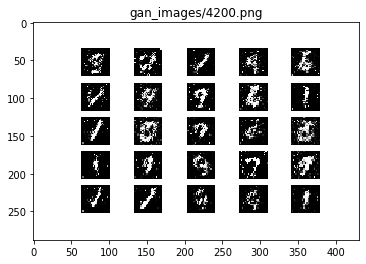

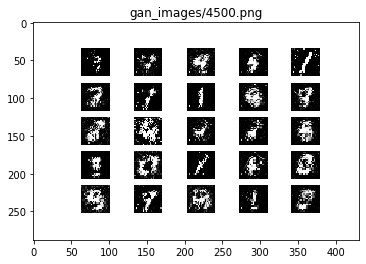

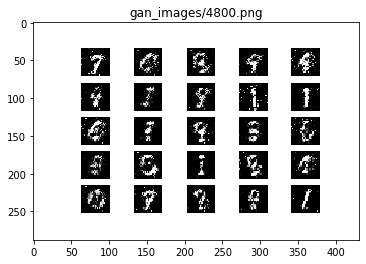

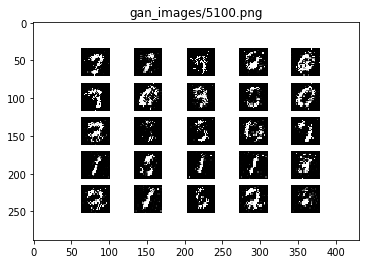

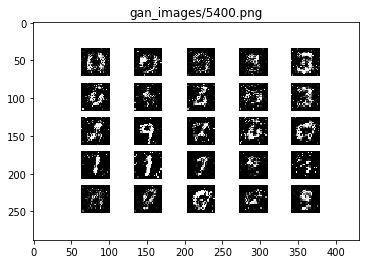

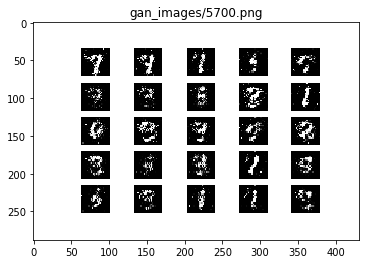

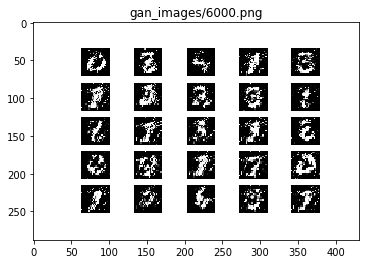

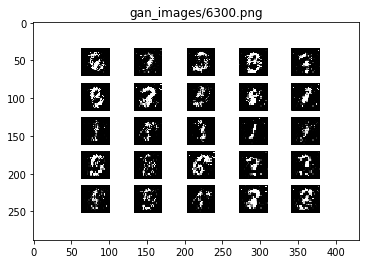

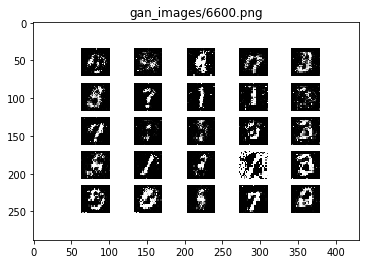

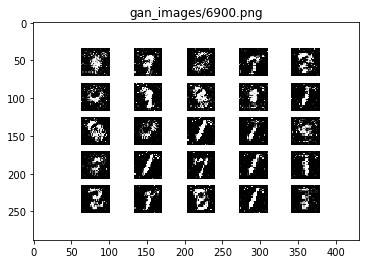

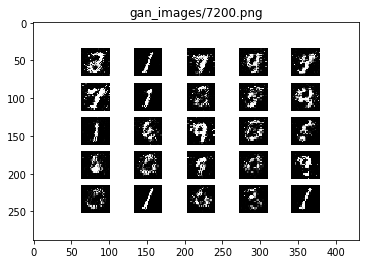

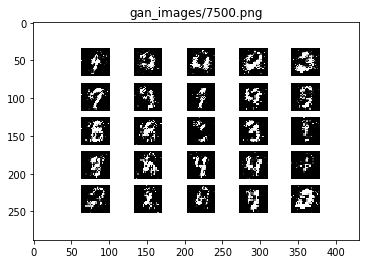

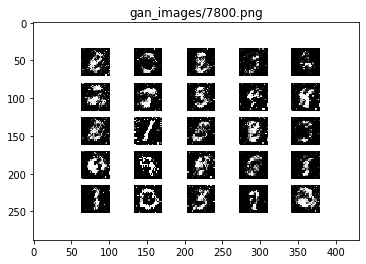

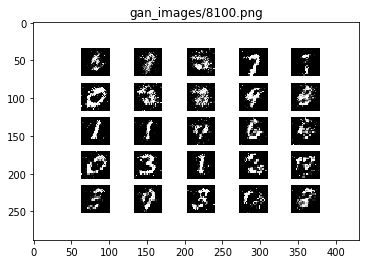

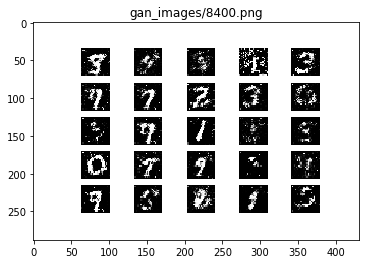

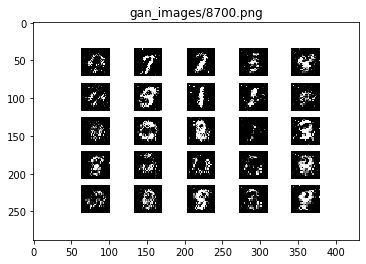

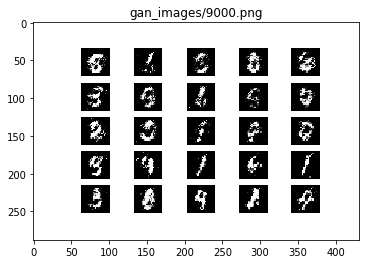

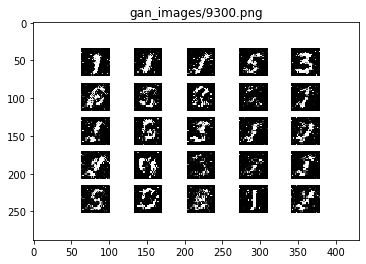

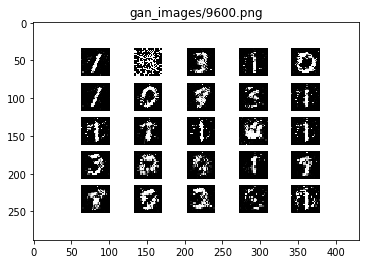

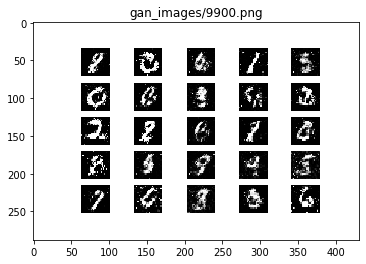

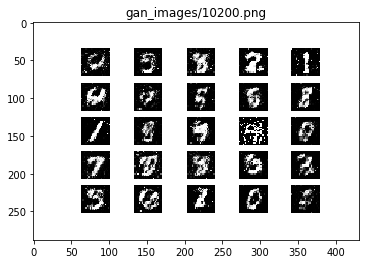

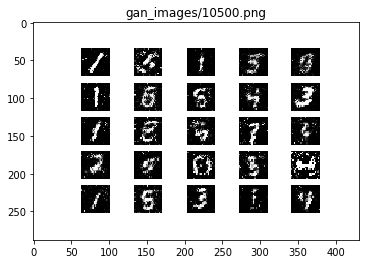

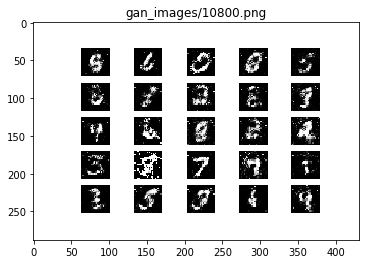

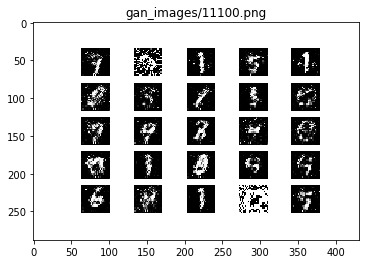

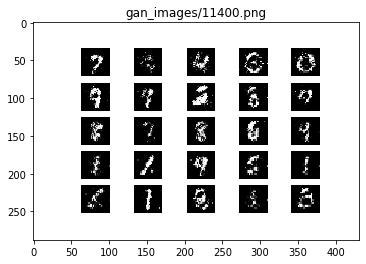

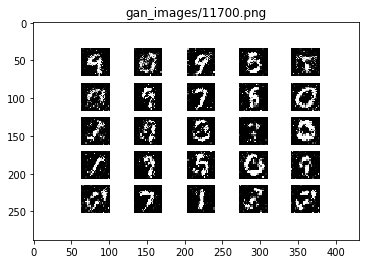

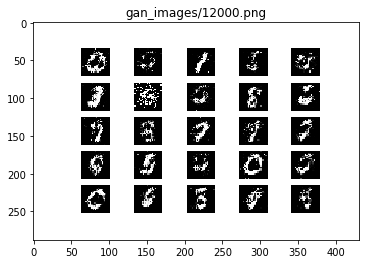

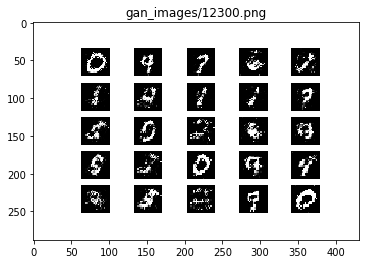

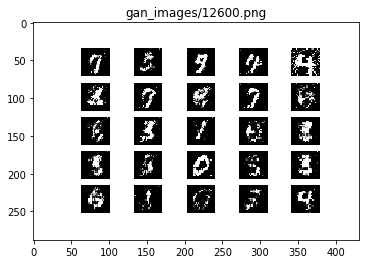

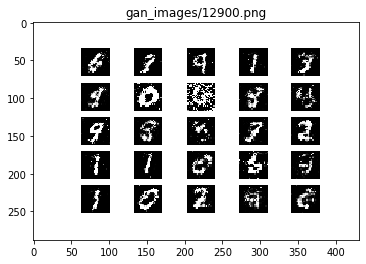

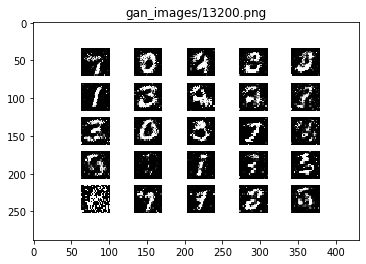

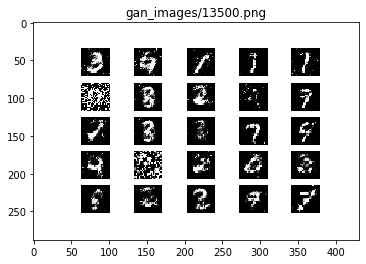

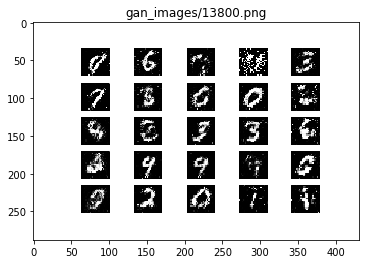

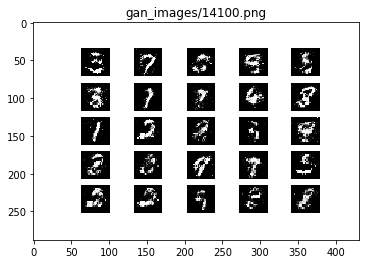

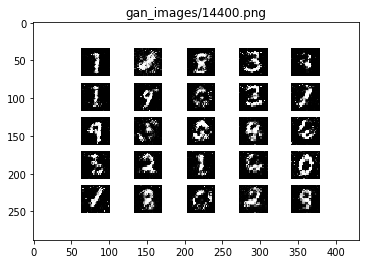

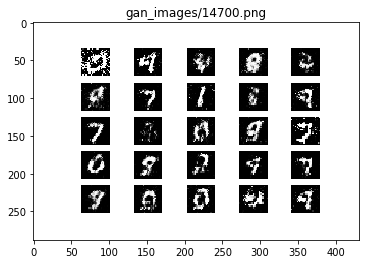

In [0]:
# Evolution of generator's drawing skills
from skimage.io import imread
for img in history['images']:
  plt.imshow(imread(img))
  plt.title(img)
  plt.show()

In [0]:
# Save images to Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

gdrive_path = '/gdrive/My Drive/Colab Notebooks/'
target_path = gdrive_path + 'gan_images/mnist/'
if not os.path.exists(target_path): os.makedirs(target_path)

for img in history['images']:
  !cp {img} {gdrive_path.replace(' ','\ ') + img}

# Train option 2: modified loss function

We do not need a combined model with this set up.

In [0]:
n_pixels = x_train.shape[1]
latent_dim = 100

generator = create_generator(latent_dim, n_pixels)
discriminator = create_discriminator(n_pixels)

We compile both generator and discriminator. We need special loss function and metric for the generaotr, where it's output is processed through the discriminator.

In [108]:
# Training functions for the discriminator
d_optimizer = tf.optimizers.Adam()
d_loss_fn = tf.losses.BinaryCrossentropy()
d_metric = tf.metrics.Accuracy()

discriminator.compile(
    optimizer=d_optimizer,
    loss=d_loss_fn,
    metrics=[d_metric]
)
discriminator.summary()
print()

# Training functions for the generator
g_optimizer = d_optimizer
def g_loss_fn(y_true, y_pred):
  return d_loss_fn(y_true, discriminator(y_pred))
def g_metric(y_true, y_pred):
  return d_metric(y_true, discriminator(y_pred))

generator.compile(
    optimizer=g_optimizer,
    loss=g_loss_fn,
    metrics=[g_metric]
)
generator.summary()
print()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_101 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_102 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 100)]             0         
___________________________

We now train the generator directly.

In [109]:
history = train_gan(generator, discriminator, scaler=scaler, epochs=15000,
                    path='gan_images/mnist')

Epoch 1/15000, d_loss: 1.32, d_acc: 0.00, [0:00:00.171228], g_loss: 1.14 g_acc: 0.00, [0:00:00.168569]
Epoch 101/15000, d_loss: 0.05, d_acc: 0.07, [0:00:06.110910], g_loss: 13.56 g_acc: 0.00, [0:00:11.774243]
Epoch 201/15000, d_loss: 0.06, d_acc: 0.03, [0:00:06.095504], g_loss: 14.34 g_acc: 0.00, [0:00:11.744853]
Epoch 301/15000, d_loss: 0.10, d_acc: 0.01, [0:00:08.034484], g_loss: 7.36 g_acc: 0.00, [0:00:11.825042]
Epoch 401/15000, d_loss: 0.10, d_acc: 0.02, [0:00:06.074873], g_loss: 3.82 g_acc: 0.00, [0:00:11.742941]
Epoch 501/15000, d_loss: 0.04, d_acc: 0.00, [0:00:06.164051], g_loss: 2.92 g_acc: 0.00, [0:00:11.843426]
Epoch 601/15000, d_loss: 0.06, d_acc: 0.00, [0:00:06.053048], g_loss: 4.46 g_acc: 0.00, [0:00:11.708699]
Epoch 701/15000, d_loss: 0.06, d_acc: 0.00, [0:00:06.054412], g_loss: 4.03 g_acc: 0.00, [0:00:11.679399]
Epoch 801/15000, d_loss: 0.17, d_acc: 0.00, [0:00:06.085089], g_loss: 4.85 g_acc: 0.00, [0:00:11.853415]
Epoch 901/15000, d_loss: 0.13, d_acc: 0.00, [0:00:06.00

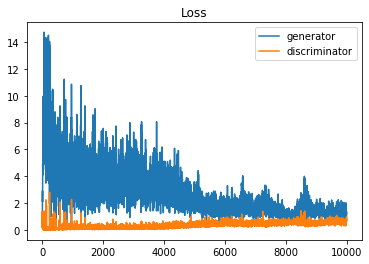

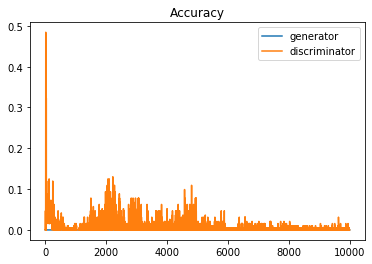

In [110]:
# Both generator and discriminator improve over time, so that loss and accuracy
# remain stable.
plt.plot(history['g_loss'], label='generator')
plt.plot(history['d_loss'], label='discriminator')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history['g_acc'], label='generator')
plt.plot(history['d_acc'], label='discriminator')
plt.title('Accuracy')
plt.legend()
plt.show()

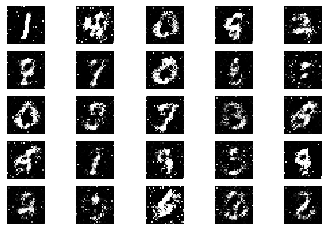

In [111]:
# The generator has learnt to turn input noise into realistic images
sample_images(generator, scaler)

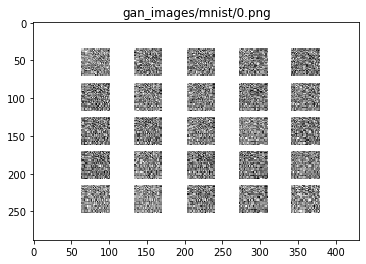

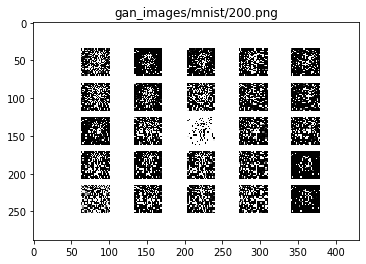

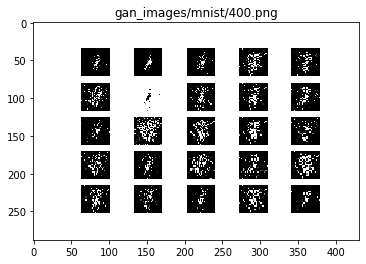

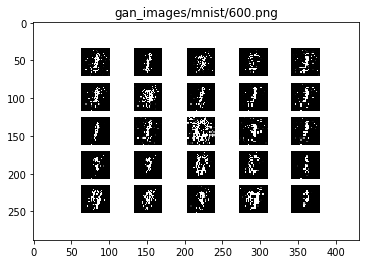

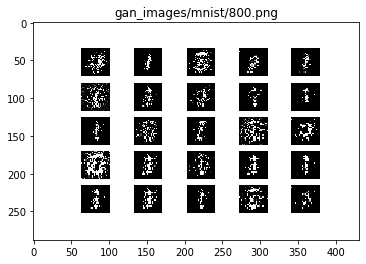

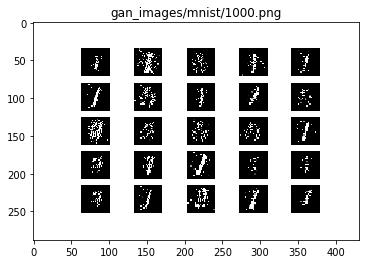

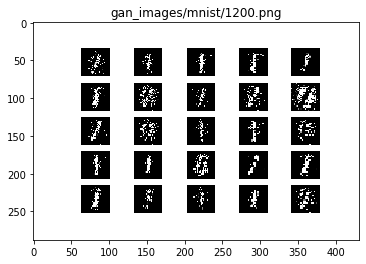

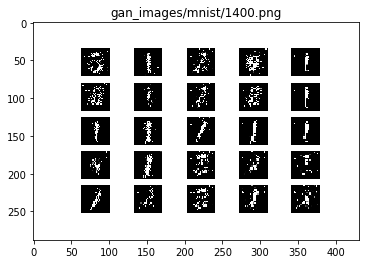

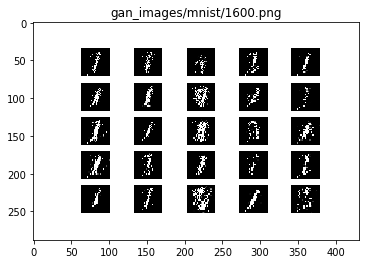

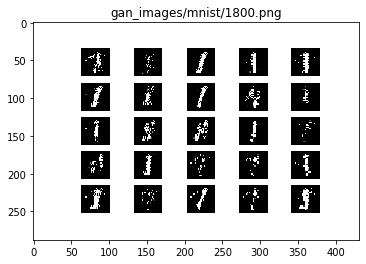

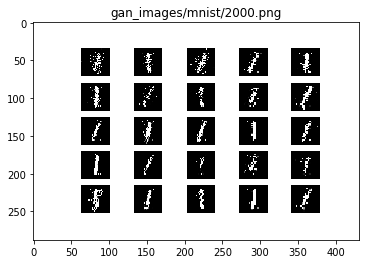

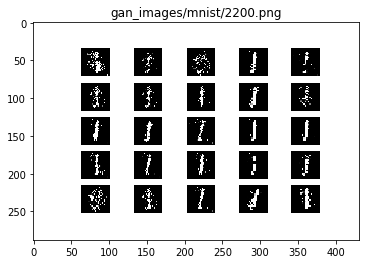

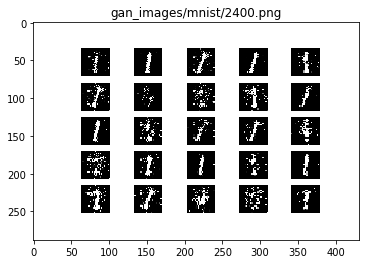

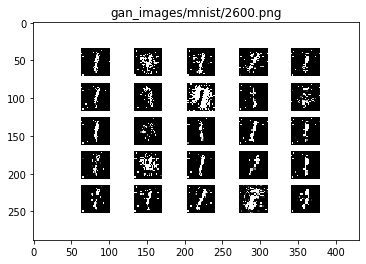

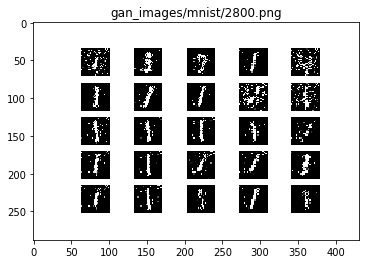

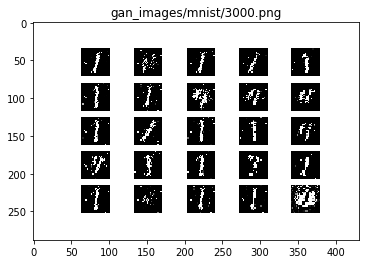

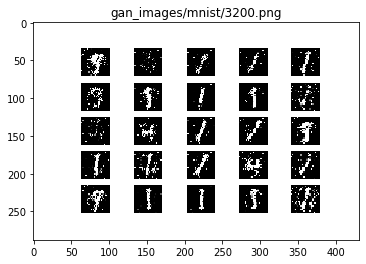

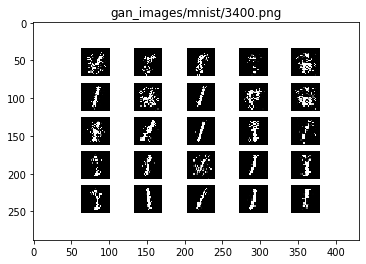

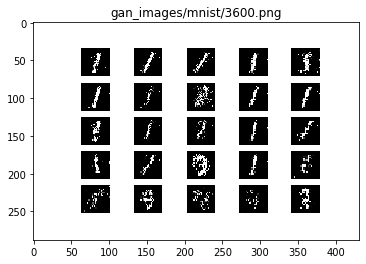

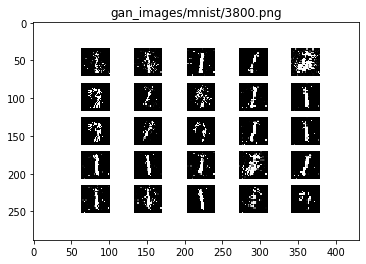

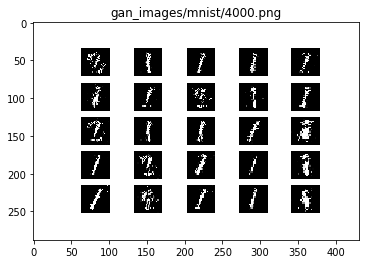

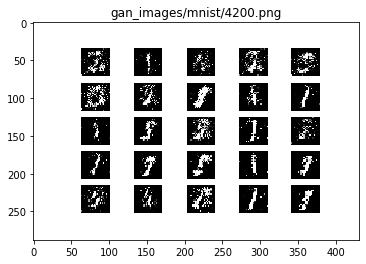

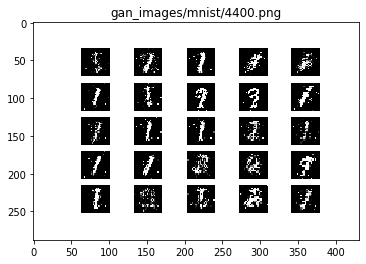

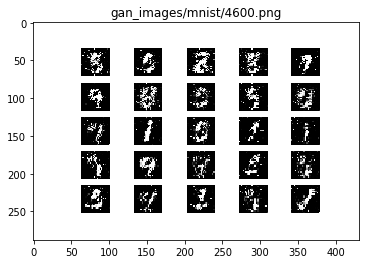

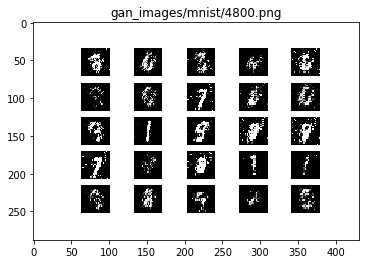

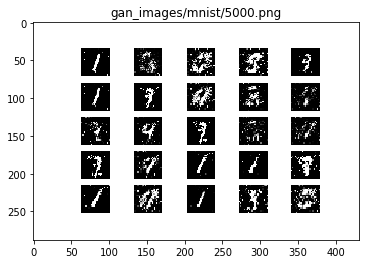

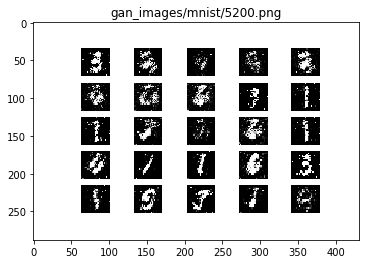

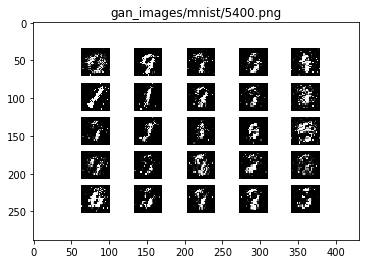

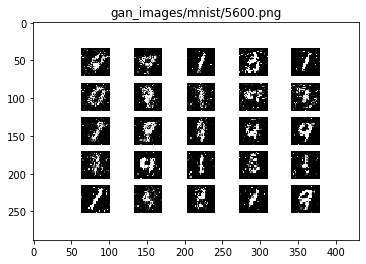

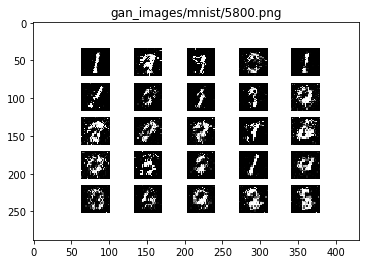

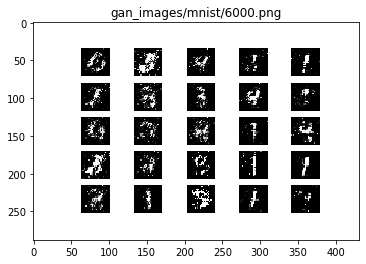

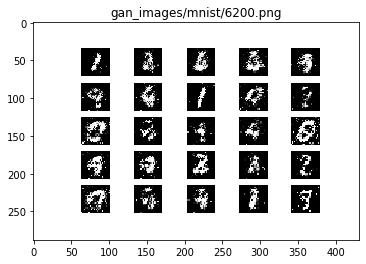

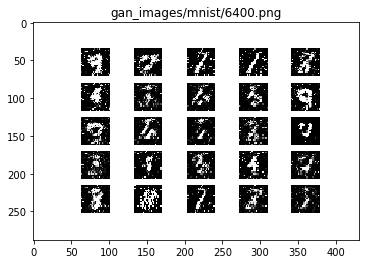

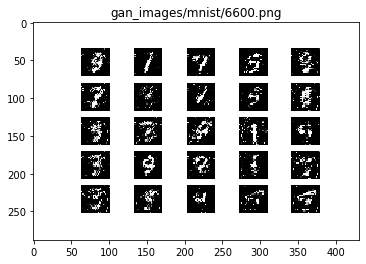

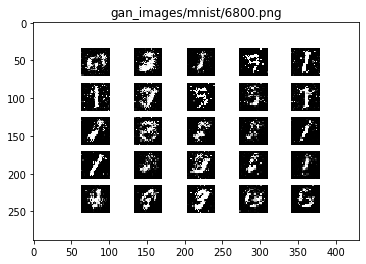

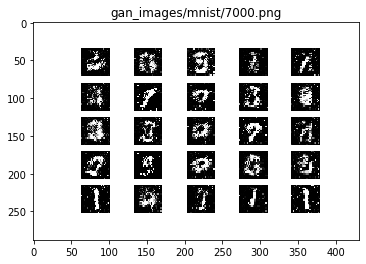

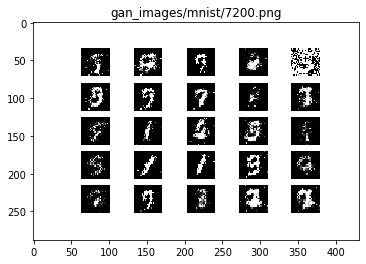

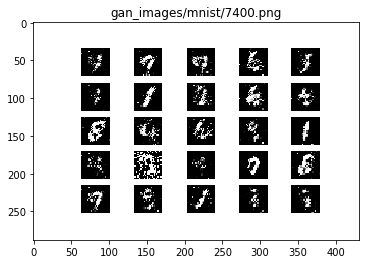

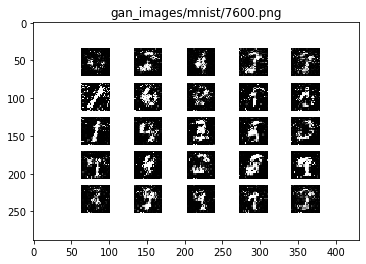

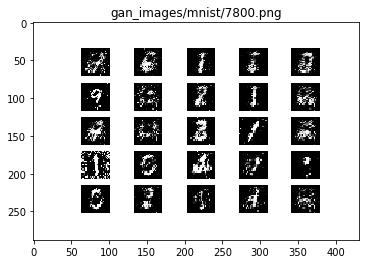

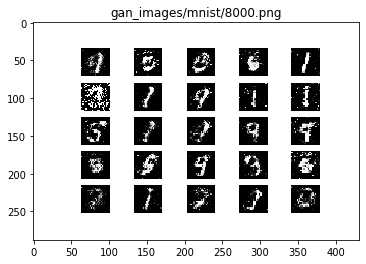

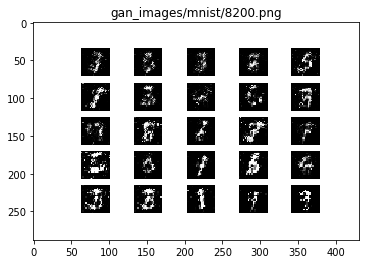

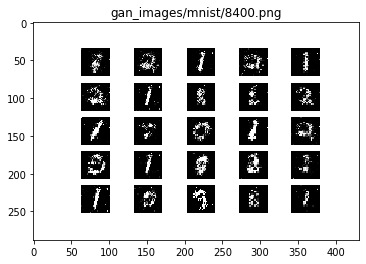

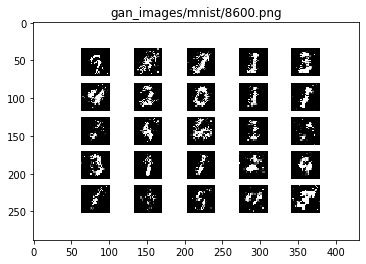

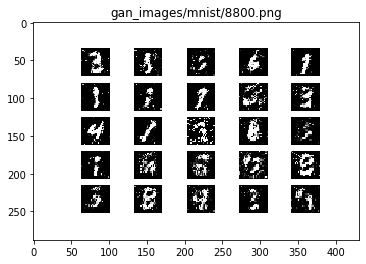

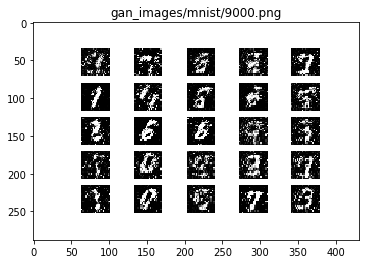

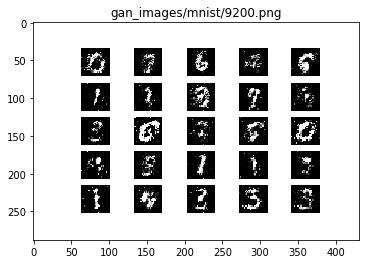

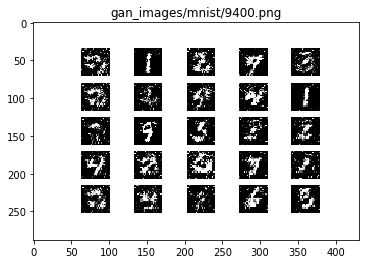

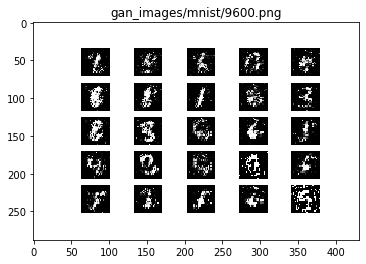

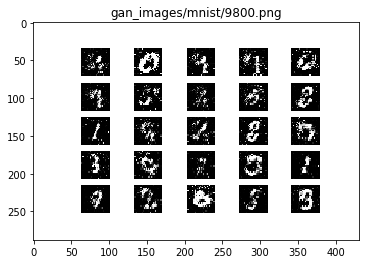

In [112]:
# Evolution of generator's drawing skills
from skimage.io import imread
for img in history['images']:
  plt.imshow(imread(img))
  plt.title(img)
  plt.show()

In [0]:
# Save images to Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

gdrive_path = '/gdrive/My Drive/Colab Notebooks/'
target_path = gdrive_path + 'gan_images/mnist/'
if not os.path.exists(target_path): os.makedirs(target_path)

for img in history['images']:
  !cp {img} {gdrive_path.replace(' ','\ ') + img}